In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# img import 및 그레이스케일 화
img = cv2.imread('img/20230517224803_00001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img, (3,3), 0)

In [3]:
# 색상 반전
# invert = img.copy()
# invert = 255 - invert
# invert.size

(2335, 1651)


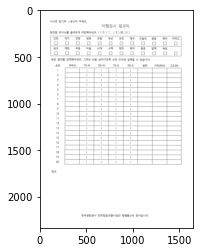

In [4]:
# 임계값 지정
# ret, thresh = cv2.threshold(img, 210, 255, cv2.THRESH_BINARY_INV)
thresh = cv2.Canny(img, 96, 255)

# dilate (팽창)
# dilate = cv2.dilate(thresh, (3,3), iterations=2)
# cv2.imshow("2", thresh)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
print(thresh.shape)
plt.imshow(thresh, cmap='binary')

In [32]:
# 가장 넓이가 큰 경계값 찾기 ( 중앙의 결과값 테이블 )
images, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# images = cv2.cvtColor(images, cv2.COLOR_GRAY2BGR)
contour_array = sorted(contours, key=cv2.contourArea, reverse=True)

table_data = contour_array[0]
x, y, w, h = cv2.boundingRect(table_data)


In [7]:
# 칸마다 마진을 두어 탐색 진행

col_count = 8
row_count = 20

margin = [4, 2]

cell_width = round(w / col_count) - margin[0]
cell_height = round(h / row_count) - margin[1]

# cv2.putText(images, "BIG AREA", (x, y), cv2.FONT_ITALIC, 10, (255, 255, 0), 2)
# cv2.rectangle(images, (x, y), (x + w, y + h), (255, 255, 0), 3)

In [8]:
coord = [x, y]
img_arr = []
for y_ in range(row_count):
    row = []
    for x_ in range(col_count):
        # if x_ == 0:
        # continue
        position = [coord[0] - round(cell_width * 0.05), coord[1] - round(cell_height * 0.05)]
        # if y_ % 2 == 0 and x_ < 4:
        #     cv2.imshow(str(y_) + '-' + str(x_),
        #                images[position[1]:position[1] + cell_height, position[0]:position[0] + cell_width])
        #     cv2.waitKey(0)
        #     cv2.destroyAllWindows()

        # cv2.rectangle(images, (position[0], position[1]),
        #               (position[0] + cell_width + round(cell_width * 0.1),
        #                position[1] + cell_height + round(cell_width * 0.1)), (255, 255, 0),
        #               thickness=2)

        row.append(images[position[1]:position[1] + cell_height + round(cell_width * 0.1),
                    position[0]:position[0] + cell_width + round(cell_width * 0.1)])

        coord[0] += cell_width + margin[0]

    img_arr.append(row)
    coord[1] += cell_height + margin[1]
    coord[0] = x

img_arr = np.array(img_arr)
# cv2.imshow("ctr", images)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
img_arr.shape  # return (row, col, height, width)

(20, 8, 66, 172)

In [9]:
for y in img_arr:
    for x in y:
        img_ctr, contours_, _ = cv2.findContours(x, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        boundary = [cv2.boundingRect(each) for each in contours_]
        boundary = sorted(boundary)

        cv2.imshow("ctr", x)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        # 가장 밖에 있는 경계선 찾기
        contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours_]
        biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]

        # 경계선 검은색으로 칠하기
        cv2.drawContours(img_ctr, biggest_contour, -1, (0,0,0), 4)

        cv2.imshow("ctr", img_ctr)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        # 칠한 경계선 지우고 다시 숫자의 경계 직사각형 찾기
        # ret_, img_th = cv2.threshold(img_ctr, 127, 255, cv2.THRESH_BINARY_INV)
        img_ctr, contours_, _ = cv2.findContours(img_ctr.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


        # 경계 직사각형 그리기
        boundary_rects = [cv2.boundingRect(each) for each in contours_]
        boundary_rects = sorted(boundary_rects)
        for rect in boundary_rects:
            minimum = (cell_width * 0.05) * (cell_height * 0.05)

            # if abs(rect[0] - rect[2]) > 10 and abs(rect[1] - rect[3]) > 10:
            if (abs(rect[0] - rect[2]) * (rect[1] - rect[3])) > minimum:
                print(f'x:{rect[0] - rect[2]} y:{rect[1] - rect[3]} | received {(rect[0] - rect[2]) * (rect[1] - rect[3])}')
                cv2.rectangle(img_ctr, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (255,255,255), 1)

        cv2.imshow("ctr", img_ctr)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        break
#
#         img_indiv, ct, hi = cv2.findContours(x, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#
#         rect = [cv2.boundingRect(each) for each in ct]
#         rect = sorted(rect)
#
#         print(rect)
#         for rec in rect:
#             # print(rec)
#             cv2.circle(img_indiv, (rec[0], rec[1]), 10, (0, 0, 255), -1)
#             cv2.circle(img_indiv, (rec[0] + rec[2], rec[1] + rec[3]), 10, (0, 0, 255), -1)
#             cv2.rectangle(img_indiv, (rec[0], rec[1]), (rec[0] + rec[2], rec[1] + rec[3]), (0, 255, 0), 3)
#         cv2.imshow('a', img_indiv)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
#


x:14 y:4 | received 56
x:13 y:4 | received 52
x:28 y:56 | received 1568
x:32 y:29 | received 928
x:35 y:23 | received 805
x:41 y:5 | received 205
x:57 y:5 | received 285
x:78 y:5 | received 390
x:89 y:5 | received 445
x:101 y:5 | received 505
x:98 y:5 | received 490
x:116 y:5 | received 580
x:120 y:5 | received 600
x:157 y:5 | received 785
x:2 y:57 | received 114
x:2 y:55 | received 110
x:9 y:55 | received 495
x:16 y:55 | received 880
x:28 y:4 | received 112
x:27 y:57 | received 1539
x:-88 y:54 | received -4752
x:4 y:55 | received 220
x:9 y:3 | received 27
x:17 y:55 | received 935
x:16 y:3 | received 48
x:23 y:55 | received 1265
x:27 y:5 | received 135
x:35 y:50 | received 1750
x:35 y:49 | received 1715
x:-88 y:2 | received -176
x:-86 y:55 | received -4730
x:10 y:55 | received 550
x:17 y:3 | received 51
x:21 y:57 | received 1197
x:23 y:3 | received 69
x:33 y:52 | received 1716
x:-88 y:54 | received -4752
x:-86 y:3 | received -258
x:-1 y:54 | received -54
x:10 y:53 | received 530
x:10 y

In [9]:
resize = cv2.resize(images, dsize=(0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
cv2.imshow("area", resize)
cv2.waitKey(0)
cv2.destroyAllWindows()